In [11]:
conda install -c conda-forge spacy


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/manak18340/anaconda3/envs/ie-embeddings

  added / updated specs:
    - spacy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    certifi-2021.10.8          |   py39hf3d152e_2         145 KB  conda-forge
    python_abi-3.9             |           2_cp39           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         288 KB

The following NEW packages will be INSTALLED:

  python_abi         conda-forge/linux-64::python_abi-3.9-2_cp39

The following packages will be SUPERSE

In [24]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz


     |████████████████████████████████| 12.0 MB 711 kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019121 sha256=9a12ac6481f27a45fd207455662326a52ca1d7775cd8be3770ad23bb07c563b3
  Stored in directory: /home/manak18340/.cache/pip/wheels/02/87/47/4d729a97cc46afa46135595b4de32d01461f05947df39166d7
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.3.1
    Uninstalling en-core-web-sm-2.3.1:
      Successfully uninstalled en-core-web-sm-2.3.1


In [22]:
!python -m spacy download en_core_web_sm


     |████████████████████████████████| 12.0 MB 2.8 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [12]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 12.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/manak18340/anaconda3/envs/ie-embeddings/lib/python3.9/site-packages/en_core_web_sm
-->
/home/manak18340/anaconda3/envs/ie-embeddings/lib/python3.9/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [13]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
import pickle
from collections import Counter
import spacy
from sklearn.metrics import silhouette_score
from spacy import displacy
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/manak18340/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /home/manak18340/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
train_triplet_to_text = pd.read_csv('../data/train_triplet_to_text.csv')
train_triplet_to_text.head()

,input_text,target_text
0,"Allen_Forrest | birthPlace | ""Fort Campbell, K...","Allen Forrest was born in Fort Campbell, KY an..."
1,Akron_Summit_Assault | ground | St._Vincent–St...,The ground of Akron Summit Assault is in St Vi...
2,Addis_Ababa_City_Hall | buildingStartDate | 19...,The Addis Ababa City Hall was built in 1961 an...
3,ALCO_RS-3 | builder | Montreal_Locomotive_Work...,The ALCO RS-3 has a V12 engine and is 17068.8 ...
4,Atlantic_City_International_Airport | operatin...,"The Port Authority of New York and New Jersey,..."


In [15]:
train_triplet_to_text["target_text"]

0        Allen Forrest was born in Fort Campbell, KY an...
1        The ground of Akron Summit Assault is in St Vi...
2        The Addis Ababa City Hall was built in 1961 an...
3        The ALCO RS-3 has a V12 engine and is 17068.8 ...
4        The Port Authority of New York and New Jersey,...
                               ...                        
28381    Antwerp International Airport serves the city ...
28382    Aaron Hunt has played for, Viktor Skrypnyk man...
28383    There are 600 students at the Accademia di Arc...
28384                  Alberto Teisaire is a Rear Admiral.
28385    Hüseyin Bütüner and Hilmi Güner designed the B...
Name: target_text, Length: 28386, dtype: object

In [16]:
text_to_tuples_dict = {}
for idx,row in train_triplet_to_text.iterrows():
    text_to_tuples_dict[row['target_text']] = row['input_text'].split("&&")

In [17]:
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text  = str(text)
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [18]:
master_dict = {} 
# dictionary format -- {text : {split_sentences: [ ] , tuples : []}}
for text in tqdm(list(text_to_tuples_dict.keys()), position = 0, desc = "Progress"):
    
    split_sentences = split_into_sentences(text)
    tuples = text_to_tuples_dict[text]
    master_dict[text] = {'split_sentences': split_sentences,
                        'tuples' : tuples}

Progress: 100%|████████████████████████████████████████████████████████████████| 28266/28266 [00:00<00:00, 28589.38it/s]


In [19]:
master_dict[list(master_dict.keys())[0]]

{'split_sentences': ['Allen Forrest was born in Fort Campbell, KY and was raised in Dothan, AL.'],
 'tuples': ['Allen_Forrest | birthPlace | "Fort Campbell, KY, raised in Dothan, AL"']}

In [20]:
from pathlib import Path

def show_dependency_graph(doc, save_file = False):
    print ("{:<15} | {:<8} | {:<15} | {:<20}".format('Token','Relation','Head', 'Children'))
    print ("-" * 70)

    for token in doc:
      # Print the token, dependency nature, head and all dependents of the token
      print ("{:<15} | {:<8} | {:<15} | {:<20}"
             .format(str(token.text), str(token.dep_), str(token.head.text), str([child for child in token.children])))

     # Use displayCy to visualize the dependency 
    img = displacy.render(doc, style='dep', jupyter=True, options={'distance': 100})
    if save_file:
        output_path = Path("dependency_plot.svg") # you can keep there only "dependency_plot.svg" if you want to save it in the same folder where you run the script 
        output_path.open("w", encoding="utf-8").write(img)
    
    




In [28]:
# nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()
for key in tqdm(list(master_dict.keys()), position = 0, desc = "Progress : "):
    
    split_sentences = master_dict[key]['split_sentences']
    dependency_relations = []
    for sentence in split_sentences:
        doc = nlp(sentence)
        dependency_relations_sentence = [doc]
        for token in doc:
            dep_dict = {}
            text = str(token.text)
            Relation = str(token.dep_)
            Head = str(token.head.text)
            Children = [str(child) for child in token.children]
#             print(text, Relation , Head, Children)
            dep_dict['text'] = text
            dep_dict['Relation'] = Relation
            dep_dict['Head'] = Head
            dep_dict['Children'] = Children
            dependency_relations_sentence.append(dep_dict)
        dependency_relations.append(dependency_relations_sentence)
    master_dict[key]['dependency_relations'] = dependency_relations
        
#         show_dependency_graph(doc)
        
    
        

/home/manak18340/anaconda3/envs/ie-embeddings/lib/python3.9/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
Progress : 100%|█████████████████████████████████████████████████████████████████| 28266/28266 [03:12<00:00, 147.17it/s]


In [29]:
sample_idx = 1
master_dict[list(master_dict.keys())[sample_idx]]['dependency_relations']

[[The ground of Akron Summit Assault is in St Vincent St Mary High School of Akron, Ohio.,
  {'text': 'The', 'Relation': 'det', 'Head': 'ground', 'Children': []},
  {'text': 'ground',
   'Relation': 'nsubj',
   'Head': 'is',
   'Children': ['The', 'of']},
  {'text': 'of',
   'Relation': 'prep',
   'Head': 'ground',
   'Children': ['Assault']},
  {'text': 'Akron', 'Relation': 'compound', 'Head': 'Summit', 'Children': []},
  {'text': 'Summit',
   'Relation': 'compound',
   'Head': 'Assault',
   'Children': ['Akron']},
  {'text': 'Assault',
   'Relation': 'pobj',
   'Head': 'of',
   'Children': ['Summit']},
  {'text': 'is',
   'Relation': 'ROOT',
   'Head': 'is',
   'Children': ['ground', 'in', '.']},
  {'text': 'in', 'Relation': 'prep', 'Head': 'is', 'Children': ['School']},
  {'text': 'St', 'Relation': 'compound', 'Head': 'Vincent', 'Children': []},
  {'text': 'Vincent',
   'Relation': 'compound',
   'Head': 'School',
   'Children': ['St']},
  {'text': 'St', 'Relation': 'compound', 'Hea

In [30]:
show_dependency_graph(master_dict[list(master_dict.keys())[sample_idx]]['dependency_relations'][0][0],save_file=False)

Token           | Relation | Head            | Children            
----------------------------------------------------------------------
The             | det      | ground          | []                  
ground          | nsubj    | is              | [The, of]           
of              | prep     | ground          | [Assault]           
Akron           | compound | Summit          | []                  
Summit          | compound | Assault         | [Akron]             
Assault         | pobj     | of              | [Summit]            
is              | ROOT     | is              | [ground, in, .]     
in              | prep     | is              | [School]            
St              | compound | Vincent         | []                  
Vincent         | compound | School          | [St]                
St              | compound | School          | []                  
Mary            | compound | School          | []                  
High            | compound | School          

In [31]:
f = open("webnlg_dependencygraph.pickle","wb")

pickle.dump(master_dict,f)
f.close()

# Clustering Test on random sentences

In [ ]:
# conda install -c conda-forge sentence-transformers 

In [ ]:
# !pip install sentence-transformers

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
sentences = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'A man is eating pasta.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.'
            ]

# Tokenization of each document
tokenized_sent = []
for s in sentences:
    tokenized_sent.append(word_tokenize(s.lower()))
tokenized_sent

In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
sentence_embeddings = sbert_model.encode(sentences)
print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])

In [ ]:
len(sentence_embeddings), sentence_embeddings.shape

In [ ]:
# Perform kmean clustering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

# Clustering Test on WebNLG data


In [21]:
sentences=list(train_triplet_to_text["target_text"])

# Tokenizaton of each document
tokenized_sent = []
for s in tqdm(sentences):
    try:
        tokenized_sent.append(word_tokenize(s.lower()))
    except:
        pass
sentence_embeddings = sbert_model.encode(sentences)
print(len(sentence_embeddings), sentence_embeddings.shape)


100%|█████████████████████████████████████| 2192/2192 [00:00<00:00, 9260.27it/s]


2192 (2192, 768)


In [22]:
num_clusters = 50
clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(sentences[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['Knightsbridge, London is the birthplace of Airey Neave, who was in World War II.', 'The Battle of Cold Harbor took place during the American Civil War and Aaron S. Daggett fought in that battle. Jefferson Davis was a commander in the American Civil War.', 'Robert E Lee was commander in the Battle of Antietam in which Aaron S. Daggett also fought.', 'Knightsbridge, London is the birthplace of Airey Neave and he was involved in the Battle of France. He started his career on 30th June 1953 and ended it on 30th March 1979.', 'Abner W. Sibal served in the United States Army and fought in WWII. He ended his military career January 3, 1965. Chiang Kai-shek was a commander in WWII.', 'Alfred Moore Scales took part in the Siege of Petersburg, which occurred during the American Civil War. A commander in the American Civil War was Abraham Lincoln.', 'Adam Koc, is of Polish nationality, the language spoken in Poland is the Kashubian language. Adam Koc, was involved in battles in the P

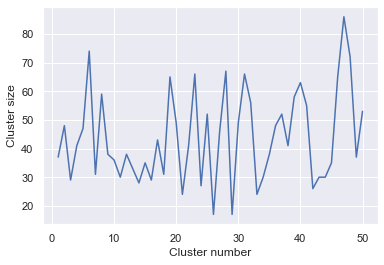

In [32]:
clust_num=[]
clust_len=[]

for i, cluster in enumerate(clustered_sentences):
    clust_num.append(i+1)
    clust_len.append(len(cluster))

plt.plot(clust_num,clust_len)
plt.xlabel('Cluster number') 
plt.ylabel('Cluster size') 
plt.show()

In [ ]:
cluster_assignment

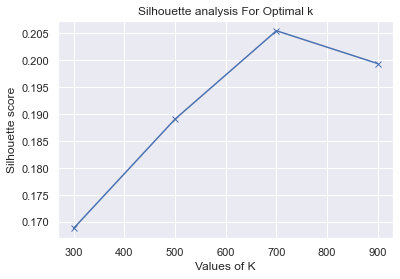

In [27]:
range_n_clusters = []
for i in range(300,1000,200):
    range_n_clusters.append(i)
silhouette_avg = []

for num_clusters in range_n_clusters:
    # initialise kmeans
    
    clustering_model = KMeans(n_clusters=num_clusters,random_state=0).fit(sentence_embeddings)
    cluster_assignment = clustering_model.labels_  

    # silhouette score
    silhouette_avg.append(silhouette_score(sentence_embeddings, cluster_assignment))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [23]:
type(sentence_embeddings),sentence_embeddings.shape

(numpy.ndarray, (2192, 768))

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

S = StandardScaler().fit_transform(sentence_embeddings)
principalComponents = pca.fit_transform(S)
principalComponents.shape

(2192, 2)

In [25]:
principalComponents[:5]

array([[  0.7241825,   0.7831753],
       [ -4.404388 ,  -2.5695136],
       [-11.612126 ,  -8.019596 ],
       [ -5.302257 ,  -1.2897866],
       [ -3.9946706,  -5.4859548]], dtype=float32)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

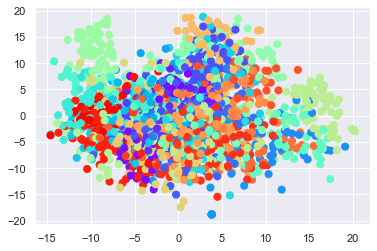

In [26]:
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=cluster_assignment, s=50, cmap='rainbow')
# plt.legend()
centers = clustering_model.cluster_centers_

In [28]:
len(centers)

50